In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

# This part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.set_session(tf.Session(config=config))

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Download & Import my custom library utilities
if tf.io.gfile.exists('./nn_utils'):
  tf.io.gfile.rmtree('./nn_utils')
!git clone https://github.com/ashxjain/nn_utils.git
  
import nn_utils.data.tfrecords as tfrecords
import nn_utils.visualize as vis

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Cloning into 'nn_utils'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 137 (delta 73), reused 98 (delta 36), pack-reused 0
Receiving objects: 100% (137/137), 22.61 KiB | 0 bytes/s, done.
Resolving deltas: 100% (73/73), done.
Checking connectivity... done.


### Use Single Tesla V100

In [2]:
!nvidia-smi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Sep  1 10:04:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   46C    P0    57W / 300W |    317MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   46C    P0    56W / 300W |    317MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Hyperparameters

In [3]:
batch_size = 128
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

### Create TFRecords for CIFAR-10 Dataset in CWD

In [4]:
tfrecords.create("cifar10", "./")

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.


W0901 10:04:10.546620 140214027335424 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0901 10:04:10.547948 140214027335424 deprecation.py:323] From /root/Ashish/nn_utils/data/tfrecords.py:26: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0901 10:04:10.549075 140214027335424 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is 

Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.


W0901 10:04:15.234030 140214027335424 deprecation_wrapper.py:119] From /root/Ashish/nn_utils/data/tfrecords.py:54: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0901 10:04:15.235785 140214027335424 deprecation_wrapper.py:119] From /root/Ashish/nn_utils/data/tfrecords.py:43: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Generating ./eval.tfrecords...Done [10000 records]
Generating ./train.tfrecords...Done [50000 records]
Done!


### Load TFRecords & Augment the loaded images

W0901 10:05:32.302821 140214027335424 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/image_ops_impl.py:1514: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0901 10:05:32.372162 140214027335424 deprecation.py:323] From <ipython-input-5-6ebf02fe136e>:27: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0901 10:05:32.616547 140214027335424 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0901 10:05:32.619488 

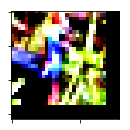

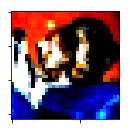

In [5]:
def preprocess(img, img_shape, training):
    img = img * (1. / 255.)
    img_height, img_width, img_depth = img_shape
    if training:
        # Resize the image to add four extra pixels on each side.
        img = tf.image.resize_image_with_crop_or_pad(
            img,
            img_height + 8,
            img_width + 8
        )

        # Randomly crop a [_height, _width] section of the image.
        img = tf.random_crop(img, img_shape)

        # Randomly flip the image horizontally.
        img = tf.image.random_flip_left_right(img)

     # Subtract off the mean and divide by the variance of the pixels.
    img = tf.image.per_image_standardization(img)
    return img


train_dataset = tfrecords.load("cifar10", ["./train.tfrecords"], batch_size, preprocess, training=True)
test_dataset = tfrecords.load("cifar10", ["./eval.tfrecords"], batch_size, preprocess, training=False)

# Visualize TFRecord Dataset
iter = train_dataset.make_initializable_iterator()
el = iter.get_next()
with tf.Session() as sess:
    sess.run(iter.initializer)
    img, lab = sess.run(el)
    vis.show_image(img[0])

iter = test_dataset.make_initializable_iterator()
el = iter.get_next()
with tf.Session() as sess:
    sess.run(iter.initializer)
    img, lab = sess.run(el)
    vis.show_image(img[0])

### Define DenseNet Blocks

In [6]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp, Conv2D_3_3])
        
        temp = concat
        
    return temp

In [7]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
        Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [8]:
def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    #relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(BatchNorm)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

### Build Architecture

In [9]:
num_filter = 12
dropout_rate = 0.2
l = 12

input = Input(shape=(32, 32, 3))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

W0901 10:05:38.291969 140214027335424 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(
    "DenseNet_16.hdf5",
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks = [checkpoint]

model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=50000//batch_size,
    validation_data=test_dataset,
    validation_steps=10000//batch_size,
    callbacks=callbacks,
)

Epoch 1/50
389/390 [============================>.] - ETA: 0s - loss: 1.7938 - acc: 0.3328
Epoch 00001: val_acc improved from -inf to 0.43490, saving model to DenseNet_16.hdf5
390/390 [==============================] - 65s 166ms/step - loss: 1.7932 - acc: 0.3328 - val_loss: 1.7548 - val_acc: 0.4349
Epoch 2/50
389/390 [============================>.] - ETA: 0s - loss: 1.4236 - acc: 0.4758
Epoch 00002: val_acc improved from 0.43490 to 0.49639, saving model to DenseNet_16.hdf5
390/390 [==============================] - 37s 95ms/step - loss: 1.4236 - acc: 0.4760 - val_loss: 1.6748 - val_acc: 0.4964
Epoch 3/50
389/390 [============================>.] - ETA: 0s - loss: 1.2525 - acc: 0.5437
Epoch 00003: val_acc improved from 0.49639 to 0.54497, saving model to DenseNet_16.hdf5
390/390 [==============================] - 37s 94ms/step - loss: 1.2523 - acc: 0.5437 - val_loss: 1.6839 - val_acc: 0.5450
Epoch 4/50
389/390 [============================>.] - ETA: 0s - loss: 1.1507 - acc: 0.5850
Epoch

In [17]:
# Test the model
model.load_weights('DenseNet_16.hdf5')
score = model.evaluate(
    test_dataset,
    steps=10000//batch_size,
    verbose=1
)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

78/78 [==============================] - 3s 35ms/step - loss: 0.6228 - acc: 0.8252
Test loss: 0.6227653450690783
Test accuracy: 0.82522035


In [0]:
from google.colab import files

files.download('DenseNet_16.hdf5')